In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import wandb
import torch
import random
import efficientnet_pytorch

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import torch.nn.functional as F

from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet

In [3]:
print(os.getenv('wandb_api_key'))

4015c794f679e3b16458b585c36e77213d391bc2


In [4]:
# os.environ

In [5]:
# print(key=os.environ['wandb_api_key'])

In [6]:
# wandb.login(key=os.environ['wandb_api_key'])
wandb.login(key='4015c794f679e3b16458b585c36e77213d391bc2')

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\rosul\.netrc


True

In [7]:
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check GPU
accelerator, torch.__version__, pl.__version__

('cuda', '2.1.1', '2.0.3')

### Config

In [8]:
data_dir = 'D:\data\HMS'

cfg = {
    'encoder': 'efficientnet-b0',
    'seed': 42,
    'cls_num': 6,
    'spect_dir': f'{data_dir}/train_spectrograms',
    'train_bs': 32,
    'val_bs': 32,
    'num_workers': 4,
    'max_epochs': 8,
    'lr': 1e-4,
    'comment': '',
}

results_dir = f'{data_dir}/results'
ckpt_path = f'{results_dir}/ckpt'

ckpt_path

'D:\\data\\HMS/results/ckpt'

In [9]:
# type(cfg)

In [10]:
try:
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    if not os.path.exists(ckpt_path):
        os.mkdir(ckpt_path)
except Exception as e:
    print(e)
    print('dir already exists')

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg['seed'])

### Data

In [12]:
train_df = pd.read_csv(f'{data_dir}/train.csv')
train_df.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

In [13]:
vote_cols = [x for x in train_df.columns if 'vote' in x]
# vote_cols

train_df['total_votes'] = train_df.loc[:, vote_cols].sum(axis=1)
train_df['cons_votes'] = train_df.loc[:, vote_cols].max(axis=1)

train_df['consensus'] = train_df['cons_votes']/train_df['total_votes']

In [14]:
vote_cols

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [15]:
train_df.sample(5)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,cons_votes,consensus
34848,352705021,30,108.0,686402130,30,108.0,393891559,38549,GPD,0,2,11,0,0,0,13,11,0.846154
49129,1758542393,5,18.0,959372535,5,18.0,4283252794,34893,GRDA,0,0,0,0,3,0,3,3,1.000000
12772,369158057,8,44.0,250501602,8,44.0,3818240317,65203,Seizure,3,0,0,0,0,0,3,3,1.000000
92397,1840011277,1,4.0,1872858502,1,4.0,1305534833,45528,LPD,0,3,0,0,0,2,5,3,0.600000
76728,2793291056,7,34.0,1540613004,7,34.0,106820417,55692,Seizure,3,0,0,0,0,0,3,3,1.000000


In [16]:
train_df.iloc[:, 3:].head()

,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,cons_votes,consensus
0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,3,3,1.0
1,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,3,3,1.0
2,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,3,3,1.0
3,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3,3,1.0
4,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,3,3,1.0


In [17]:
train_df[vote_cols].div(train_df['total_votes'], axis=0).sample(5)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
80819,0.0,0.916667,0.0,0.000000,0.0,0.083333
39923,0.0,0.266667,0.0,0.466667,0.0,0.266667
63838,1.0,0.000000,0.0,0.000000,0.0,0.000000
31958,0.0,0.333333,0.0,0.333333,0.0,0.333333
13656,0.0,0.000000,0.0,0.333333,0.0,0.666667


### Dataset

In [18]:
from hms_dataset import spectro_dataset

In [19]:
dset = spectro_dataset(df=train_df, base_dir=cfg['spect_dir'], cols=vote_cols)
print(dset.__len__())

spect, target, = dset.__getitem__(1)
print(spect.shape, target.shape)
print(spect.dtype, target.dtype)

106800
torch.Size([4, 100, 300]) (6,)
torch.float32 float32


<Figure size 640x480 with 0 Axes>

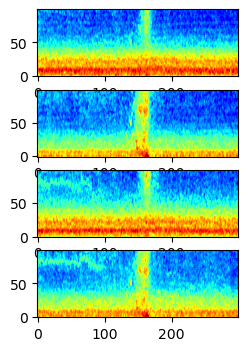

In [20]:
def print_spectros(spectro, lg=True):
    plt.figure()
    f, axs = plt.subplots(4,1)
    f.set_figheight(4)
    f.set_figwidth(12)
    
    # spectro = np.clip(spectro,np.exp(-4),np.exp(8))
    # if lg == True:
    #     spectro = np.log(spectro)
    
    for i in range(4):
        start = i*100+1
        
        img = spectro[i]
        
        # img = spectro.iloc[:,start:start+100]
            
        axs[i].imshow(img, origin='lower', cmap='jet')
        
    plt.show()

print_spectros(spect)

In [21]:
# print_spectros(spect, lg=False)

### Datamodule

In [22]:
class spectro_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, train_bs=cfg['train_bs'], val_bs=cfg['val_bs'], num_workers=cfg['num_workers'],):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        
        self.train_bs = train_bs
        self.val_bs = val_bs
        
        self.num_workers = num_workers
        
    def train_dataloader(self):
        train_ds = spectro_dataset(self.train_df, base_dir=cfg['spect_dir'], cols=vote_cols)
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = spectro_dataset(self.val_df, base_dir=cfg['spect_dir'], cols=vote_cols)
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        
        return val_loader

In [23]:
t_df = train_df[:-400]
v_df = train_df[-400:]

bs = 64

dm = spectro_datamodule(
    t_df,
    v_df, 
    train_bs=bs,
)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([64, 4, 100, 300]),
 torch.Size([64, 6]),
 torch.float32,
 torch.float32)

### Model

In [24]:
# from torchmetrics.classification import Accuracy as Accuracy
import torchmetrics as tm 

In [32]:
class spectro_model(pl.LightningModule):
    def __init__(self, cfg,):
        super().__init__()
        
        self.cfg = cfg
        self.encoder=cfg['encoder']
        
#         self.criterion = nn.NLLLoss()
        self.train_acc = tm.classification.MulticlassAccuracy(num_classes=cfg['cls_num'])
        self.val_acc = tm.classification.MulticlassAccuracy(num_classes=cfg['cls_num'])
        
        self.criterion = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction="batchmean")
        
        self.model = EfficientNet.from_pretrained(
            self.encoder, 
            in_channels=4, 
            num_classes=cfg['cls_num'],
        )
        
    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=0.015)
        
    def forward(self, x):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode='train'):
        x, y = batch
        
        preds = self(x)
        
        # loss = self.criterion(preds, y)

        kl_loss = self.kl_loss(F.log_softmax(preds, dim=1), y)
        loss = kl_loss
        
        if mode == 'train':
            self.train_acc(preds, y.argmax(1))
        else:
            self.val_acc(preds, y.argmax(1))
        
#         values = {f'{mode}/loss': loss, }
#         self.log_dict(values)
        
        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)
        self.log(f'{mode}/kl_loss', kl_loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        self.log(f'train/acc', self.train_acc, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss =  self.step(batch, batch_idx, mode='val')
        self.log(f'val/acc', self.val_acc, on_step=True, on_epoch=True)
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.reset()
        self.val_acc.reset()

In [33]:
model = spectro_model(cfg)

Loaded pretrained weights for efficientnet-b0


In [34]:
# foo = model(x.nan_to_num(0))
foo = model(x)
foo.shape

torch.Size([64, 6])

In [35]:
y.shape, foo.shape

(torch.Size([64, 6]), torch.Size([64, 6]))

In [36]:
y.argmax(1)

tensor([2, 0, 1, 4, 3, 0, 0, 0, 1, 1, 5, 0, 0, 4, 2, 5, 5, 3, 1, 3, 0, 5, 1, 5,
        5, 3, 0, 4, 0, 1, 0, 3, 3, 1, 5, 0, 2, 2, 1, 2, 0, 1, 2, 0, 5, 4, 1, 3,
        0, 2, 0, 3, 1, 2, 4, 0, 0, 1, 5, 1, 5, 2, 0, 3])

In [37]:
y[:5], foo[:5]

(tensor([[0.0667, 0.0000, 0.8000, 0.0667, 0.0667, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.7500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7000, 0.3000],
         [0.0000, 0.0000, 0.0000, 0.6667, 0.0000, 0.3333]]),
 tensor([[-3.6464e-04, -3.8905e-01,  1.2650e-01,  2.6060e-01, -2.0338e-01,
          -1.4843e-01],
         [ 1.8772e-01,  2.3083e-01, -3.5071e-02,  2.5279e-01, -5.9183e-01,
           4.8511e-01],
         [-1.3712e-01,  3.2517e-01, -1.8665e-01,  2.4796e-01, -1.9217e-02,
           5.2647e-02],
         [ 4.9320e-02,  3.2711e-02, -1.0459e-01,  1.6853e-01, -1.6491e-01,
           2.4195e-01],
         [ 1.5756e-01,  1.2656e-01,  2.5036e-01,  1.4744e-01, -2.7825e-01,
           6.9404e-02]], grad_fn=<SliceBackward0>))

In [38]:
model.training_step((x, y), 0)

C:\Users\rosul\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\core\module.py:407: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(1.4458, grad_fn=<DivBackward0>)

### Split

In [39]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [40]:
# rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=seed)
# train_idx, val_idx = next(rs.split(sequences_df))

In [41]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=cfg['seed'])
train_idx, val_idx = next(sss.split(train_df.eeg_id, train_df.expert_consensus))

t_df = train_df.iloc[train_idx]
v_df = train_df.iloc[val_idx]

t_df.shape, v_df.shape

((96120, 18), (10680, 18))

### Train

In [42]:
dm = spectro_datamodule(t_df,v_df)

In [43]:
len(dm.train_dataloader()), len(dm.val_dataloader())

(3004, 334)

In [44]:
model = spectro_model(cfg)

Loaded pretrained weights for efficientnet-b0


In [45]:
from pytorch_lightning.loggers import WandbLogger

In [46]:
wandb_logger = WandbLogger(
    name=f'{cfg["encoder"][-2:]} {cfg["max_epochs"]} eps {cfg["comment"]}',
    project='HMS-spectro-local',
    job_type='train',
    save_dir=results_dir,
    config=cfg,
)

In [47]:
# wandb.init()

In [48]:
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [49]:
loss_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/loss',
    dirpath=ckpt_path,
    filename='loss-{epoch:02d}-{val/loss:.2f}',
    save_top_k=1,
    mode='min',
)

In [50]:
trainer = pl.Trainer(
    max_epochs=cfg['max_epochs'],
    deterministic=True,
    accelerator=accelerator,
    default_root_dir=results_dir,
    logger=wandb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0     
1 | val_acc   | MulticlassAccuracy | 0     
2 | criterion | CrossEntropyLoss   | 0     
3 | kl_loss   | KLDivLoss          | 0     
4 | model     | EfficientNet       | 4.0 M 
-------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.062    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


In [52]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/acc_epoch,▁▆▇██▇▇▆
train/acc_step,▁▆▄▅▄▅▆▅▇▄▅▆▆█▆▃▆▃▆▅▇█▄▆▆▇▅▇▅▆▅▆█▆▆▅▆▆▅▇
train/kl_loss_epoch,█▃▂▁▁▁▂▂
train/kl_loss_step,█▄▄▃▄▃▂▂▂▅▂▃▂▁▂▃▂▃▂▂▂▁▂▁▁▂▂▂▂▃▃▃▂▃▃▂▄▃▃▂
train/loss_epoch,█▃▂▁▁▁▂▂
train/loss_step,█▄▄▃▄▃▂▂▂▅▂▃▂▁▂▃▂▃▂▂▂▁▂▁▁▂▂▂▂▃▃▃▂▃▃▂▄▃▃▂
trainer/global_step,▁▁▁▁▁▂▁▁▁▁▃▁▁▁▁▄▁▁▁▁▅▁▁▁▁▆▁▂▂▂▇▂▂▂▂█▂▂▂█
val/acc_epoch,▆▅█▃▇▁▆▆
val/acc_step,▆▅▆▇▅▄▆▃▆▆▇▅▆██▅▃▆▁▄▆▅▆▇▇▃▁▃▅▄▅▅▅▆▄▆▆▃▇▅
val/kl_loss_epoch,▄▃▁▃▁█▂▃


### Predict

In [54]:
# foo = model(x.to(accelerator))
foo = model(x)
foo.shape

torch.Size([64, 6])

In [55]:
foo[5:10]

tensor([[ 2.6872, -1.9469,  0.4101, -2.5456,  0.4265,  0.3813],
        [ 3.5247, -2.2756, -0.5614, -1.8056,  0.8055, -0.2874],
        [-0.5503, -0.0383, -0.2956, -0.3450, -0.1864,  0.8557],
        [ 0.1743,  2.7239, -0.8458, -0.1860, -2.4206,  0.1386],
        [-1.0966,  2.5750, -0.4032,  0.2052, -1.7527,  0.1404]],
       grad_fn=<SliceBackward0>)

In [ ]:
y[5:10]

In [60]:
torch.nn.functional.softmax(foo, dim=-1)[:5]

tensor([[1.5112e-02, 3.2165e-03, 9.6853e-01, 3.6455e-04, 6.2855e-03, 6.4946e-03],
        [1.3463e-01, 3.1978e-01, 8.3228e-02, 2.9486e-02, 4.0015e-02, 3.9287e-01],
        [1.4904e-01, 4.7700e-01, 9.5962e-02, 5.3851e-02, 6.2936e-02, 1.6121e-01],
        [1.6693e-02, 9.4427e-03, 7.7634e-03, 4.4542e-02, 6.7156e-01, 2.4999e-01],
        [6.3223e-03, 3.2864e-02, 3.9872e-03, 6.7000e-01, 4.2430e-02, 2.4440e-01]],
       grad_fn=<SliceBackward0>)

In [59]:
torch.nn.functional.softmax(foo, dim=-1).argmax(dim=-1)

tensor([2, 5, 1, 4, 3, 0, 0, 5, 1, 1, 5, 3, 0, 4, 2, 5, 5, 3, 1, 3, 0, 5, 1, 5,
        5, 3, 0, 4, 0, 1, 5, 3, 3, 1, 3, 0, 5, 2, 0, 2, 4, 1, 2, 0, 0, 4, 0, 4,
        0, 2, 0, 3, 1, 5, 4, 5, 0, 2, 5, 5, 5, 1, 0, 3])

In [61]:
y.argmax(dim=-1)

tensor([2, 0, 1, 4, 3, 0, 0, 0, 1, 1, 5, 0, 0, 4, 2, 5, 5, 3, 1, 3, 0, 5, 1, 5,
        5, 3, 0, 4, 0, 1, 0, 3, 3, 1, 5, 0, 2, 2, 1, 2, 0, 1, 2, 0, 5, 4, 1, 3,
        0, 2, 0, 3, 1, 2, 4, 0, 0, 1, 5, 1, 5, 2, 0, 3])

In [ ]:
(torch.nn.functional.softmax(foo, dim=-1).argmax(dim=-1) == y.argmax(dim=-1)).sum()

In [ ]:
# model.save_hyperparameters()